In [71]:
from pycocotools.coco import COCO
from pathlib import Path
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
import numpy as np

In [2]:
cocoGt = COCO('evaluation/gt.json')
cocoDt = cocoGt.loadRes('evaluation/pred.json')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


In [4]:
cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.30s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

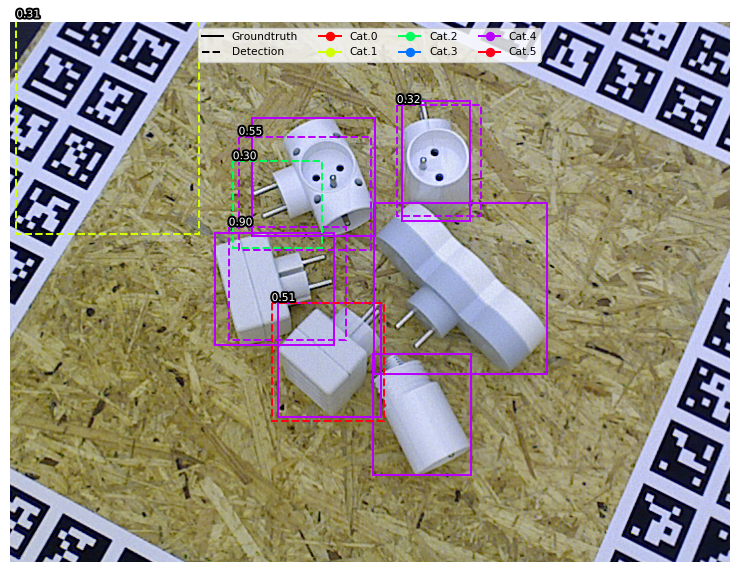

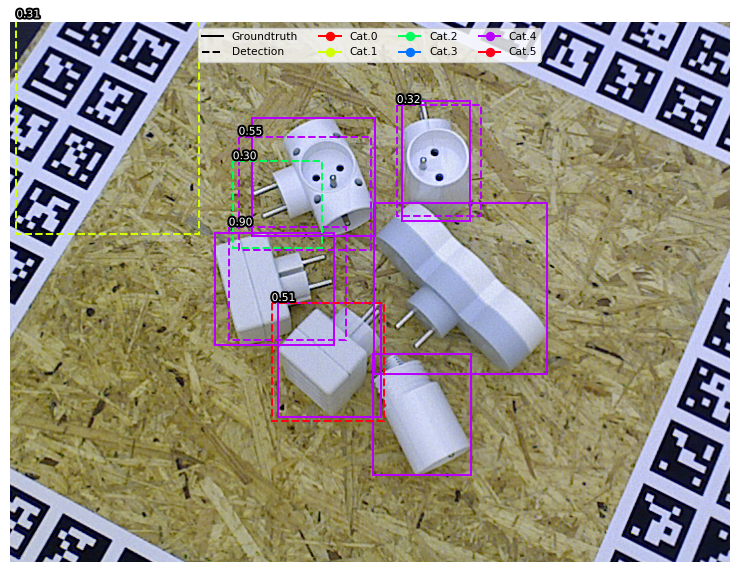

In [89]:
DS_PATH = Path(r'C:\data\tless_test_primesense\tless_test_primesense_bop19\test_primesense')
LINEWIDTH=1.5
FONTSIZE=8
DPI=96

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def draw_bbox(ax, bbox, text=None, linestyle=None, color=None):
    [bbox_x, bbox_y, bbox_w, bbox_h] = bbox
    poly = [
        [bbox_x, bbox_y], 
        [bbox_x, bbox_y+bbox_h],
        [bbox_x+bbox_w, bbox_y+bbox_h], 
        [bbox_x+bbox_w, bbox_y]
    ]    
    np_poly = np.array(poly).reshape((4,2))
    ax.add_patch(Polygon(np_poly, linestyle=linestyle, facecolor='none', edgecolor=color, linewidth=LINEWIDTH))
    if text is not None:
        t = ax.text(bbox_x, bbox_y-2, text, fontsize=FONTSIZE, color='white')        
        t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])


def show_annotations(img_id, coco_gt, coco_dt, cat_ids=None, legend=True, min_score=0.1, show_score=False):
    if cat_ids is None:
        cat_ids = coco_gt.getCatIds()
        
    cmap = get_cmap(len(cat_ids))
        
    img_meta = coco_gt.loadImgs([img_id])[0]
    img = plt.imread(str(DS_PATH/img_meta['file_name']))
    
    gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[img_id], catIds=cat_ids, iscrowd=None))
    dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[img_id], catIds=cat_ids, iscrowd=None))
    dt_anns = [a for a in dt_anns if a['score']>=min_score]
    
    fig = plt.figure(figsize=(img.shape[1]/DPI, img.shape[0]/DPI), dpi=DPI, frameon=False)
    ax = fig.add_axes([0,0,1.,1.])
    ax.imshow(img, origin='upper')
    ax.set_axis_off()
    
    for ann in gt_anns:
        draw_bbox(ax, ann['bbox'], text=None, linestyle='-', color=cmap(ann['category_id']))
        
    for ann in dt_anns:
        text = f'{ann["score"]:.2f}' if show_score else None
        draw_bbox(ax, ann['bbox'], text=text, linestyle='--', color=cmap(ann['category_id']))
        
    if legend:
        legend_elements = [Line2D([0], [0], linestyle='-', color='k', label='Groundtruth'),
                           Line2D([0], [0], linestyle='--', color='k', label='Detection')]    
        legend_elements.extend([Line2D([0], [0], marker='o', color=cmap(c), label=f'Cat.{c}') for c in cat_ids])
        ax.legend(handles=legend_elements, loc='upper center', ncol=4, prop={'size': FONTSIZE})
        
    return fig
    
show_annotations(900, cocoGt, cocoDt, min_score=0.3, show_score=True)

In [91]:
from tqdm.notebook import tqdm
import shutil
outpath = Path('tmp/cocoeval')
outpath.mkdir(parents=True, exist_ok=True)
shutil.copy('evaluation/gt.json', outpath/'gt.json')
shutil.copy('evaluation/pred.json', outpath/'pred.json')

pbar = tqdm()
pbar.reset(total=len(cocoGt.getImgIds()))
for imgid in cocoGt.getImgIds():
    fig = show_annotations(imgid, cocoGt, cocoDt, min_score=0.3, show_score=True)
    fig.savefig(str(outpath / f'cocoeval_{imgid:04d}.png'))
    plt.close(fig)
    pbar.update()
pbar.refresh()
    

WindowsPath('tmp/cocoeval/pred.json')